In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
sys.path.append('/content/drive/My Drive/Deepfake-Detection/data-and-notebooks')
import zipfile
import time
import os
import cv2
import numpy as np
import json
import tensorflow as tf
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten, concatenate, LSTM, Lambda, TimeDistributed
from keras.models import Model, load_model, model_from_json
from keras.backend import expand_dims
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, CSVLogger
from VideoDataGenerator import VideoDataGenerator
import tensorflow as tf
from keras.layers import Reshape, Dense, Input, Conv2D, MaxPooling2D, Flatten, concatenate, LSTM, Lambda, TimeDistributed, Dropout, BatchNormalization
from keras.models import Model
from keras.backend import expand_dims
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def loadMetadata(file):
    jsonFile =  open(file)
    data = json.load(jsonFile)

    labels = {}
    testIDs = []
    validIDs = []
    # every fifth key is validID, the rest are testID
    
    for validID in data['valid'].keys():
        validIDs.append(validID)
        labels[validID] = {
          'label': data['valid'][validID]['label'],
          'audioPrediction': data['valid'][validID]['fakeAudioPrediction']
        }
        
    for testID in data['test'].keys():
        testIDs.append(testID)
        labels[testID] = {
          'label': data['test'][testID]['label'],
          'audioPrediction': data['test'][testID]['fakeAudioPrediction']
        }
        
    return (testIDs, validIDs, labels, len(testIDs), len(validIDs))













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 90, 150, 150, 0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 90, 148, 148, 112         input_1[0][0]                    
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 90, 74, 74, 4 0           time_distributed_1[0][0]         
__________________________________________________________________________________________________
time_distributed_3 (TimeDistrib (None, 90, 74, 74, 4 16         

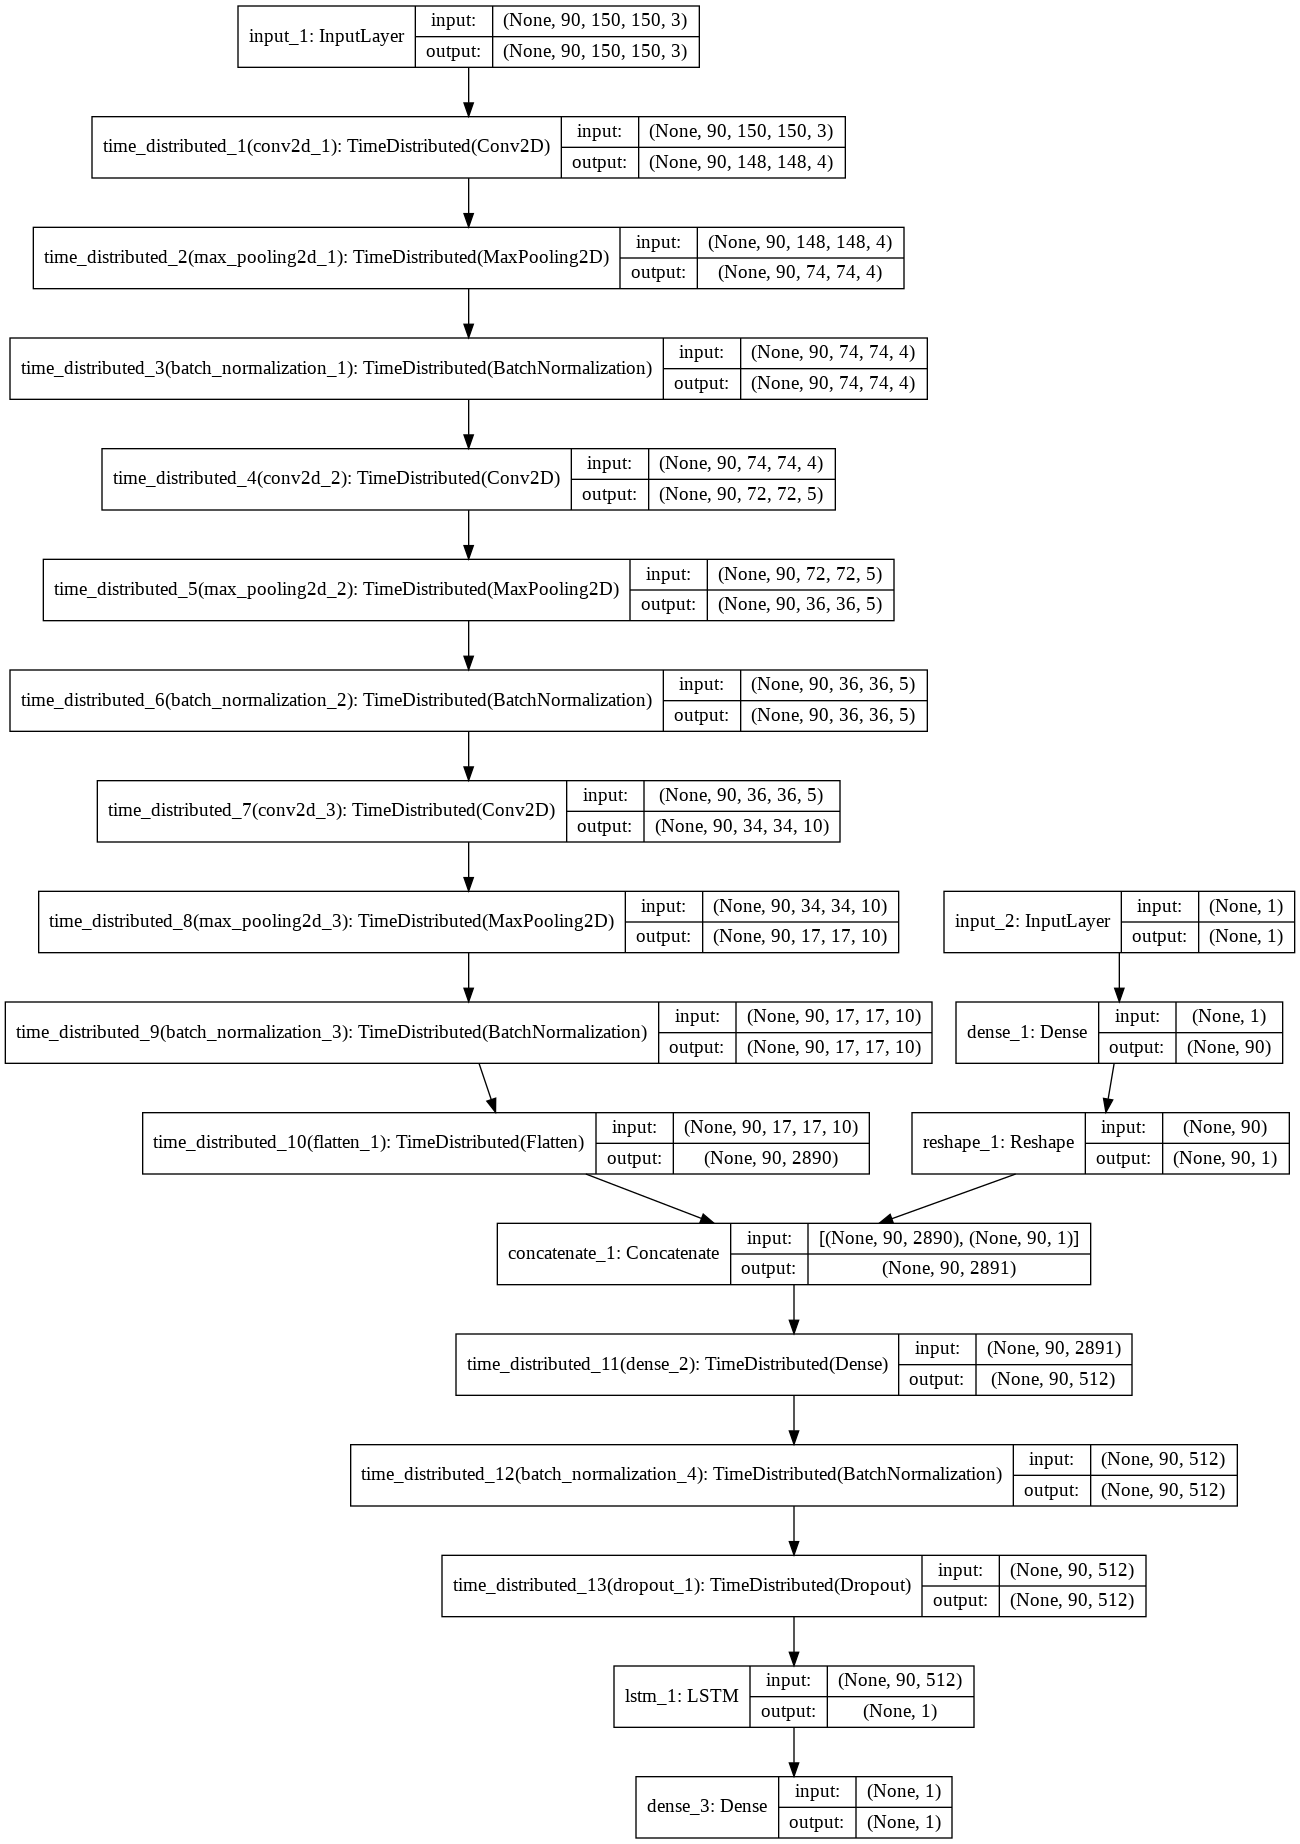

In [10]:
#    -- Image PreProcessing Model --

# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
vid_input = Input(shape=(90, 150, 150, 3))

# First convolution extracts 4 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
# MaxPooling is followed by batch normalization to reduce overfitting

model = TimeDistributed(Conv2D(4, (3,3), activation='relu'))(vid_input)
model = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(model)
model = TimeDistributed(BatchNormalization())(model)

# Second convolution extracts 5 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
# MaxPooling is followed by batch normalization to reduce overfitting

model = TimeDistributed(Conv2D(5, (3,3), activation='relu'))(model)
model = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(model)
model = TimeDistributed(BatchNormalization())(model)

# Third convolution extracts 10 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
# MaxPooling is followed by batch normalization to reduce overfitting

model = TimeDistributed(Conv2D(10, (3,3), activation='relu'))(model)
model = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(model)
model = TimeDistributed(BatchNormalization())(model)

model = TimeDistributed(Flatten())(model)

#    -- Audio PreProcessing Model --
aud_input = Input(shape=(1,))

# Create 90 copies of audio input using a dense layer with linear activation
# Extend the dimensions of aud_model so concat dim matches CNN model output.
aud_model = Dense(90, activation='linear')(aud_input)
aud_model = Reshape((90,1))(aud_model)

#     -- Concatenate Layers --
model = concatenate([model, aud_model])

# Add a Dense layer
# Normalize and add a dropout to decrease overfitting
model = TimeDistributed(Dense(512, activation='relu'))(model)
model = TimeDistributed(BatchNormalization())(model)
model = TimeDistributed(Dropout(0.4))(model)

model = LSTM(1)(model)

# Take output of LSTM and run through sigmoid activation
output = Dense(1, activation='sigmoid')(model)

model = Model(inputs=[vid_input, aud_input], outputs=output)

print(model.summary())
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [0]:
modelDirectory = '/home/jbschmid/models/v4'
dataDirectory = '/home/jbschmid/merged_data'

modelPath = os.path.join(modelDirectory, 'model.h5')
loadWeightsPath = os.path.join(modelDirectory, 'weights.h5')
saveWeightsPath = os.path.join(modelDirectory, 'weights.h5')
historyPath = os.path.join(modelDirectory, 'history.csv')
metadataPath =  './processed-metadata.json'

# load model
#model.save(modelPath)

model.compile(loss = 'binary_crossentropy',
              optimizer = RMSprop(lr = 0.001),
              metrics = ['acc'])

# Load previous training weights
#model.load_weights(loadWeightsPath)
checkpoint = ModelCheckpoint(filepath=saveWeightsPath, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

csvLogger = CSVLogger(historyPath, append=True, separator=',')

(testIDs, validIDs, labels, numTestIDs, numValidIDs) = loadMetadata(metadataPath)

epochs = 50
batchSize = 20
testStepsPerEpoch = int(numTestIDs / batchSize)
validStepsPerEpoch = int(numValidIDs / batchSize)

testGen = VideoDataGenerator(testIDs, labels, dataDirectory, 
                             batchSize=batchSize, videoDim=(150,150,3))
validGen = VideoDataGenerator(validIDs, labels, dataDirectory, 
                              batchSize=batchSize, videoDim=(150,150,3))


# Train model
history = model.fit_generator(
      generator=testGen,
      steps_per_epoch=testStepsPerEpoch,  
      epochs=epochs,
      validation_data=validGen,
      validation_steps=validStepsPerEpoch,
      workers=8,
      callbacks=[checkpoint, csvLogger]
      )


Epoch 1/50
389/389 [==============================] - 606s 2s/step - loss: 0.6730 - acc: 0.5647 - val_loss: 0.6743 - val_acc: 0.5552

Epoch 00001: val_acc improved from -inf to 0.55515, saving model to /home/jbschmid/models/v4/weights.h5
Epoch 2/50
389/389 [==============================] - 610s 2s/step - loss: 0.6266 - acc: 0.6023 - val_loss: 0.6182 - val_acc: 0.5887

Epoch 00002: val_acc improved from 0.55515 to 0.58866, saving model to /home/jbschmid/models/v4/weights.h5
Epoch 3/50
389/389 [==============================] - 596s 2s/step - loss: 0.6076 - acc: 0.6199 - val_loss: 0.5807 - val_acc: 0.6258

Epoch 00003: val_acc improved from 0.58866 to 0.62577, saving model to /home/jbschmid/models/v4/weights.h5
Epoch 4/50
389/389 [==============================] - 596s 2s/step - loss: 0.5715 - acc: 0.6497 - val_loss: 0.6544 - val_acc: 0.5990

Epoch 00004: val_acc did not improve from 0.62577
Epoch 5/50
389/389 [==============================] - 595s 2s/step - loss: 0.5438 - acc: 0.6775 


Epoch 00042: val_acc did not improve from 0.81804
Epoch 43/50
389/389 [==============================] - 592s 2s/step - loss: 0.3179 - acc: 0.8834 - val_loss: 0.5227 - val_acc: 0.8041

Epoch 00043: val_acc did not improve from 0.81804
Epoch 44/50
389/389 [==============================] - 589s 2s/step - loss: 0.3284 - acc: 0.8808 - val_loss: 0.5239 - val_acc: 0.8041

Epoch 00044: val_acc did not improve from 0.81804
Epoch 45/50
389/389 [==============================] - 588s 2s/step - loss: 0.3226 - acc: 0.8810 - val_loss: 0.5094 - val_acc: 0.8180

Epoch 00045: val_acc improved from 0.81804 to 0.81804, saving model to /home/jbschmid/models/v4/weights.h5
Epoch 46/50
389/389 [==============================] - 590s 2s/step - loss: 0.3200 - acc: 0.8826 - val_loss: 0.5217 - val_acc: 0.8057

Epoch 00046: val_acc did not improve from 0.81804
Epoch 47/50
389/389 [==============================] - 591s 2s/step - loss: 0.3166 - acc: 0.8825 - val_loss: 0.5290 - val_acc: 0.8046

Epoch 00047: val_

Text(0.5, 1.0, 'Training and validation loss')

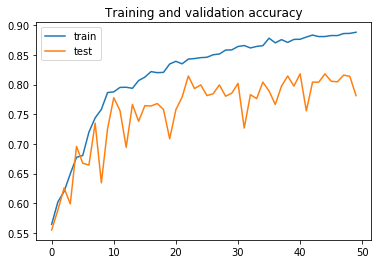

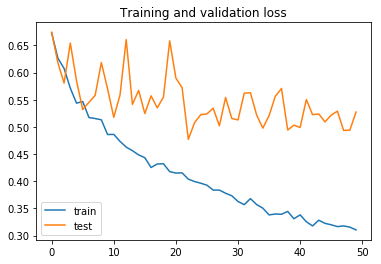

In [0]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.legend(['train', 'test'], loc='upper left')
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.legend(['train', 'test'], loc='lower left')
plt.title('Training and validation loss')